In [1]:
import numpy as np
import pandas as pd
import gym
import copy
import random
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam, RMSprop
import sklearn
import sklearn.preprocessing
from numpy.random import seed
SEED = 1337
seed(SEED)

Using TensorFlow backend.


In [2]:
env = gym.make("MountainCar-v0")
gamma = 0.99

In [3]:
# Во избежание всякого зла будем нормализовать состояние
state_space_samples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(state_space_samples)

def scale_state(state): 
    scaled = scaler.transform([state])
    return scaled

In [4]:
class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, element):
        """Сохраняет элемент в циклический буфер"""
        if len(self.memory) < self.capacity:
            self.memory.append(element)
        else:
            self.memory.pop(0)
            self.memory.append(element)

    def sample(self, batch_size):
        """Возвращает случайную выборку указанного размера"""
        return list(zip(*random.sample(self.memory, batch_size)))
    
    def __len__(self):
        return len(self.memory)

In [5]:
def create_model():
    model = Sequential()
    model.add(Dense(400, input_shape=(2,), activation='elu'))
    model.add(Dense(40, activation='elu'))
    model.add(Dense(3))
    model.compile(loss='mse', optimizer='adam')
    return model

In [6]:
def get_action(model, state, eps):
    if random.random() < eps:
        return random.randint(0, 2)
    return model.predict(np.matrix(state)).argmax()

In [7]:
def update(model, target_model, batch):
    state, action, reward, next_state, not_done = batch
    preds = model.predict(np.array(state))
    t_preds = target_model.predict(np.array(next_state))
    for i in range(len(state)):
        preds[i, action[i]] = reward[i] + gamma * not_done[i] * t_preds[i].max()
    model.train_on_batch(np.array(state), preds)   

In [8]:
#Размер одного батча, который на вход принимает модель
batch_size = 32
#Количество эпизодом
n_episodes = 200
max_epsilon = 1.0
min_epsilon = 0.1
tau = 0.01

def train():
    #Создаем модель и буфер
    memory = Memory(10000)
    model = create_model()
    target_model = keras.models.clone_model(model)
    rewards_mean = []
    rewards_std = []
    step = 0

    for episode in range(n_episodes):        
        state = env.reset()
        done = False
        while not done:
            epsilon = max(max_epsilon - episode * (max_epsilon - min_epsilon) / 10, min_epsilon)
            action = get_action(model, scale_state(state), epsilon)
            new_state, reward, done, _ = env.step(action)
            good_end = done * (new_state[0] >= 0.5)
            modified_reward = reward
            memory.push((scale_state(state)[0], action, modified_reward, scale_state(new_state)[0], not good_end))
            state = new_state
            step += 1
            # Тренируем model и обновляем веса target_model 
            if step > 100:
                update(model, target_model, memory.sample(batch_size))
                old_weights = np.array(target_model.get_weights()) * (1 - tau)
                new_weights = np.array(model.get_weights()) * tau
                target_model.set_weights(old_weights + new_weights)
        
        # Тестим модельку
        list_of_rewards = []
        list_of_max_states = []
        for i in range(100):
            done = False
            state = env.reset()
            total_reward = 0
            max_state = -1.5
            while not done:
                action = get_action(target_model, scale_state(state), 0)
                state, reward, done, _ = env.step(action)
                max_state = max(max_state, state[0])
                total_reward += reward
            list_of_rewards.append(total_reward)
            list_of_max_states.append(max_state)
        state = env.reset()
        done = False
        rewards_mean.append(np.mean(list_of_rewards))
        rewards_std.append(np.std(list_of_rewards))
        print('mean: %.2f, std: %.2f, ave max state: %.2f' % (np.mean(list_of_rewards), np.std(list_of_rewards), np.mean(list_of_max_states)))
    return rewards_mean, rewards_std, model

In [9]:
means, stds, model = train()

mean: -197.71, std: 6.63, ave max state: -0.35
mean: -200.00, std: 0.00, ave max state: -0.24
mean: -200.00, std: 0.00, ave max state: -0.28
mean: -200.00, std: 0.00, ave max state: -0.27
mean: -200.00, std: 0.00, ave max state: -0.27
mean: -200.00, std: 0.00, ave max state: -0.26
mean: -200.00, std: 0.00, ave max state: -0.26
mean: -200.00, std: 0.00, ave max state: -0.27
mean: -200.00, std: 0.00, ave max state: -0.26
mean: -200.00, std: 0.00, ave max state: -0.27
mean: -200.00, std: 0.00, ave max state: -0.25
mean: -200.00, std: 0.00, ave max state: -0.25
mean: -200.00, std: 0.00, ave max state: -0.26
mean: -200.00, std: 0.00, ave max state: -0.27
mean: -200.00, std: 0.00, ave max state: -0.27
mean: -200.00, std: 0.00, ave max state: -0.26
mean: -200.00, std: 0.00, ave max state: -0.27
mean: -200.00, std: 0.00, ave max state: -0.11
mean: -112.43, std: 13.47, ave max state: 0.52
mean: -113.72, std: 10.88, ave max state: 0.53
mean: -133.05, std: 32.95, ave max state: 0.53
mean: -200.00

mean: -125.63, std: 29.88, ave max state: 0.51
mean: -123.07, std: 29.59, ave max state: 0.51
mean: -126.15, std: 29.01, ave max state: 0.52
mean: -125.96, std: 26.53, ave max state: 0.53
mean: -122.15, std: 27.55, ave max state: 0.52
mean: -128.66, std: 27.02, ave max state: 0.53
mean: -125.60, std: 24.05, ave max state: 0.52
mean: -122.69, std: 29.00, ave max state: 0.53
mean: -123.17, std: 28.20, ave max state: 0.53
mean: -124.34, std: 28.64, ave max state: 0.53
mean: -120.95, std: 30.98, ave max state: 0.52
mean: -118.83, std: 29.38, ave max state: 0.52
mean: -123.31, std: 27.41, ave max state: 0.52
mean: -121.28, std: 28.06, ave max state: 0.52
mean: -125.30, std: 27.37, ave max state: 0.53
mean: -125.40, std: 27.73, ave max state: 0.53
mean: -122.92, std: 30.82, ave max state: 0.52
mean: -134.05, std: 28.20, ave max state: 0.53
mean: -125.90, std: 29.81, ave max state: 0.53
mean: -107.87, std: 22.93, ave max state: 0.52
mean: -105.90, std: 7.72, ave max state: 0.52
mean: -111.20,

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

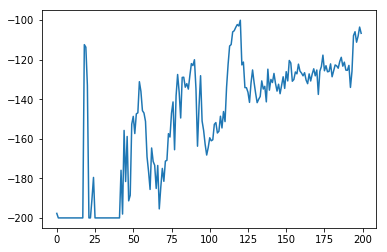

In [11]:
plt.plot(means)
plt.show()